### Importy

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import pandas as pd
from typing import Union, Tuple, List, Callable
import time
import matplotlib.pyplot as plt

import sys, os
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, PROJECT_ROOT)


from src.performance_metrics.performance_metrics import PerformanceMetrics
from src.performance_metrics.metrics_mesaurements import compare_metrics_df, plot_execution_times
from src.data.load_data import load_breath_cancer_data, load_students_data, prepare_data
from src.models.abstract_classifier import AbstractClassifier

### Załadnowanie danych

In [2]:
breast_cancer_data = load_breath_cancer_data()

breast_cancer_data.head()

,ID,Diagnosis,radius1,texture1,perimiter1,area1,smoothness1,compactness1,concavity1,concave_points1,...,radius3,texture3,perimiter3,area3,smoothness3,compactness3,concavity3,concave_points3,symetry3,fractial_dimention3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
students_data = load_students_data()
students_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


# Porównanie własnej implementacji metryk z biblioteką sklearn

### Pomocnicze funkcjie

In [19]:
def compare_all_metrics(performance_metrics, actual, predictions):
    micro = compare_metrics_df(performance_metrics, actual, predictions, average='micro')
    macro = compare_metrics_df(performance_metrics, actual, predictions, average='macro')
    per_class = compare_metrics_df(performance_metrics, actual, predictions, average='per_class')
    weighted = compare_metrics_df(performance_metrics, actual, predictions, average='weighted')

    # displaing the results
    print("Micro Average Metrics:")
    display(micro)
    print("Macro Average Metrics:")
    display(macro)
    print("Per Class Metrics:")
    display(per_class)
    print("Weighted Average Metrics:")
    display(weighted)


def compare_times(our_function, sklearn_function, predictions, actual):
    TYPES = ['micro', 'macro', 'per_class', 'weighted']
    for t in TYPES:
        print(f"--- {t} ---")
        plot_execution_times(
            our_function,
            sklearn_function,
            predictions, actual,
            ns=list(range(1, 40)),
            average=t
)

### Załadowanie danych

In [4]:
x_breast_cancer, x_test_breast_cancer, y_train_breast_cancer, y_test_breast_cancer = prepare_data(
    breast_cancer_data, target_column="Diagnosis")

In [7]:
x_students, x_test_students, y_train_students, y_test_students = prepare_data(
    students_data, target_column="G1", stratify=False)

### Modele

In [8]:
logistic_regression = LogisticRegression(max_iter=1000)
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
linear_svc = LinearSVC(max_iter=1000)
mlp_classifier = MLPClassifier(max_iter=1000)

### 1. Logistic Regression

#### Breast Cancer

In [25]:
logistic_regression_classifier_breast = AbstractClassifier(logistic_regression, x_breast_cancer, x_test_breast_cancer, y_train_breast_cancer)
logistic_regression_classifier_breast.fit()

In [26]:
predictions = logistic_regression_classifier_breast.predict()
actual = y_test_breast_cancer

performance_metrics = PerformanceMetrics(predictions, actual)


In [27]:
compare_all_metrics(performance_metrics, actual, predictions)

Micro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.921053,0.921053
precision,0.921053,0.921053
recall,0.921053,0.921053
f1,0.921053,0.921053


Macro Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.897817,0.921053
precision,0.935081,0.935081
recall,0.897817,0.897817
f1,0.911757,0.911757


Per Class Metrics:


metric          precision                       recall            \
source PerformanceMetrics   sklearn PerformanceMetrics   sklearn   
B                0.898734  0.898734           0.986111  0.986111   
M                0.971429  0.971429           0.809524  0.809524   

metric                 f1            
source PerformanceMetrics   sklearn  
B                0.940397  0.940397  
M                0.883117  0.883117

Weighted Average Metrics:


,PerformanceMetrics,sklearn
accuracy,0.921053,0.921053
precision,0.925516,0.925516
recall,0.921053,0.921053
f1,0.919294,0.919294


--- micro ---


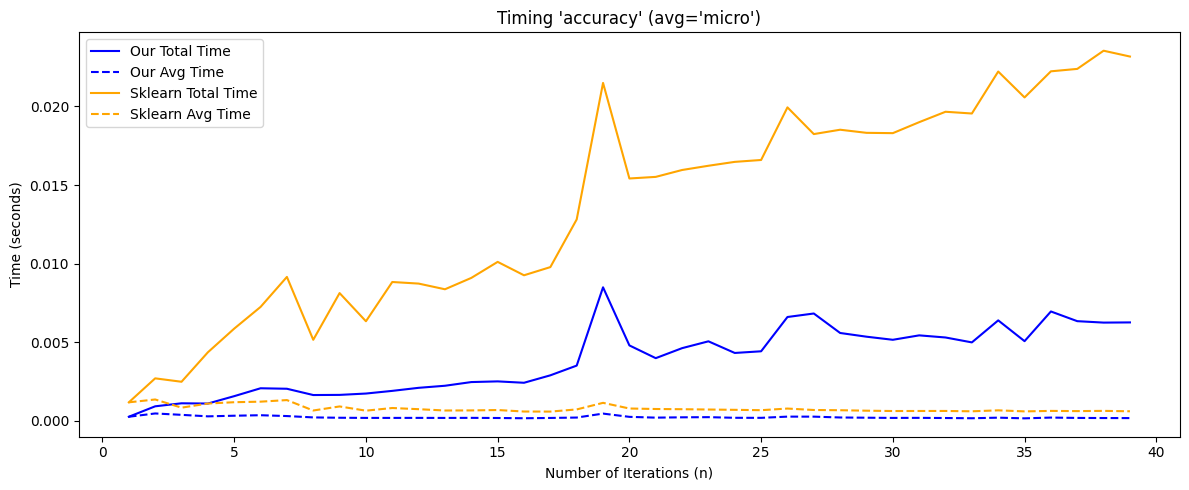

--- macro ---


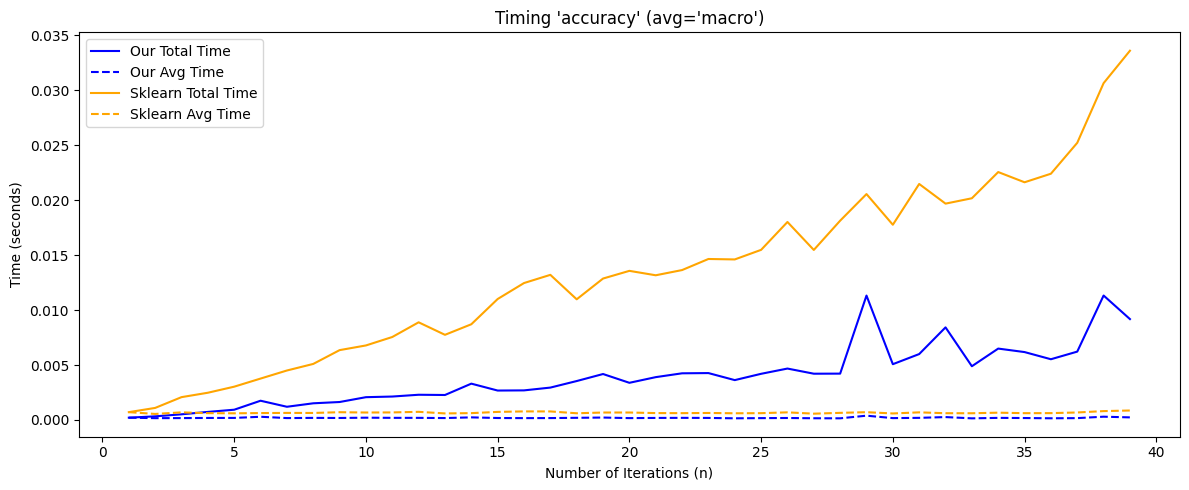

--- per_class ---


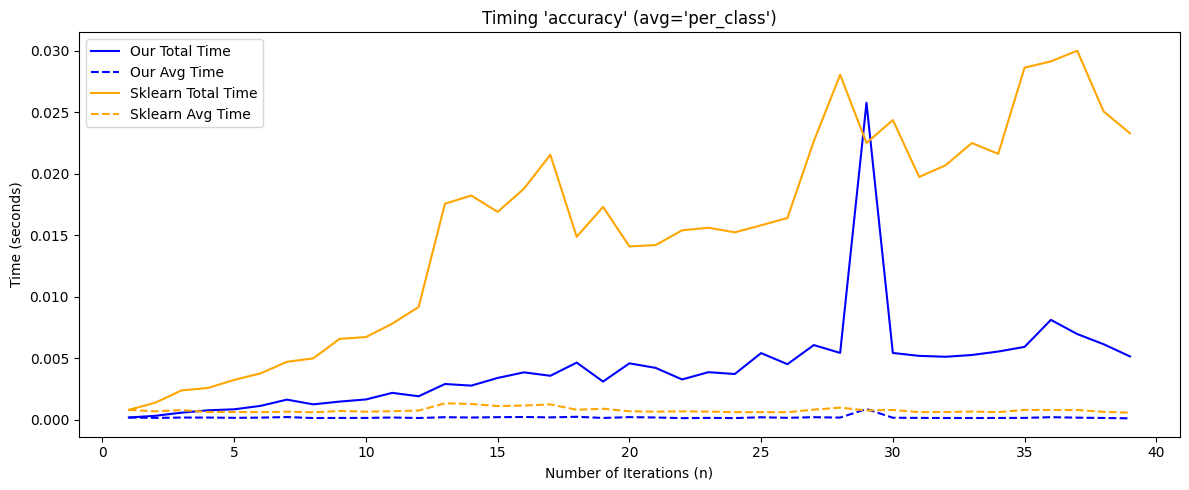

--- weighted ---


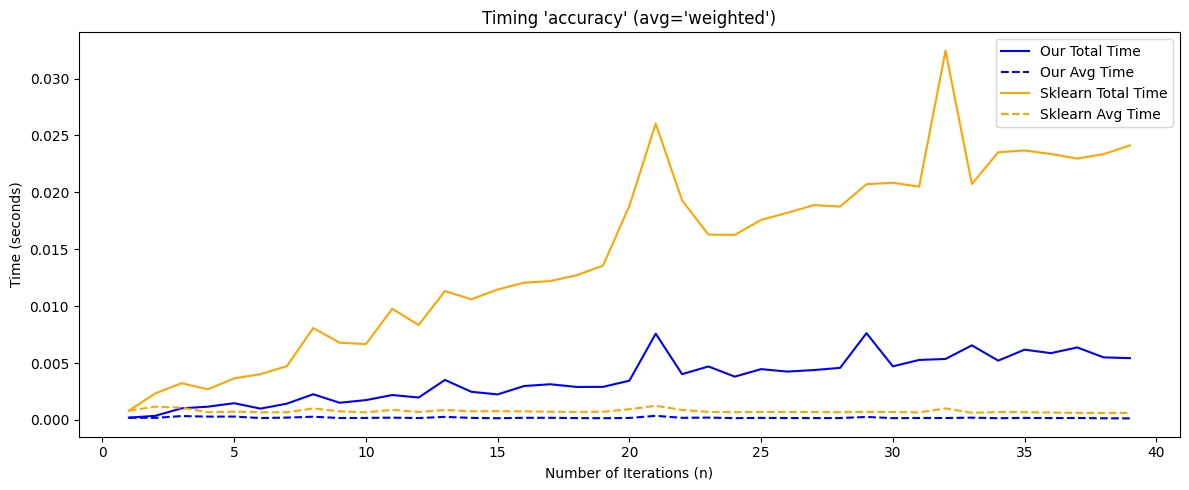

In [21]:
compare_times('accuracy', accuracy_score, predictions, actual)

--- micro ---


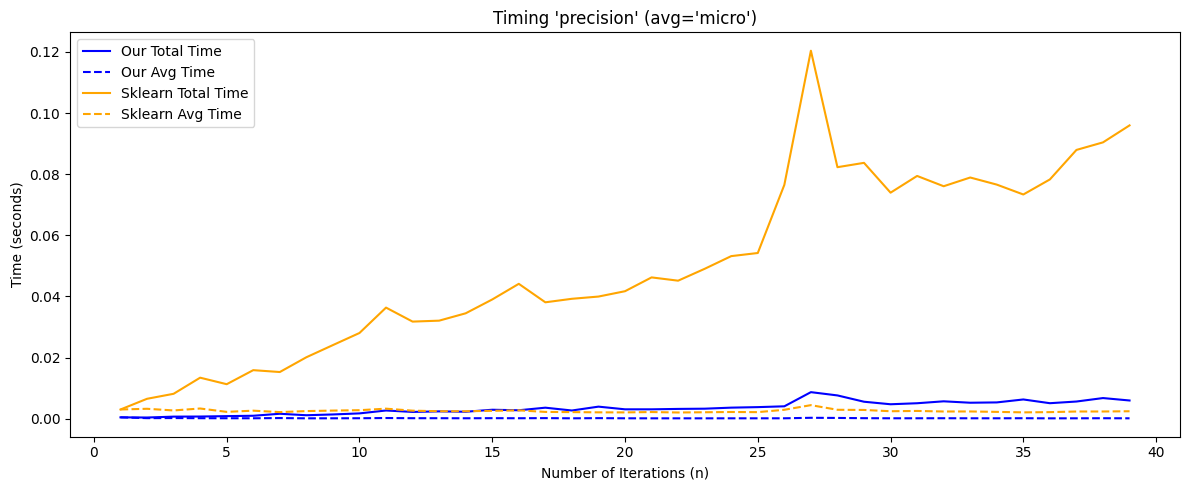

--- macro ---


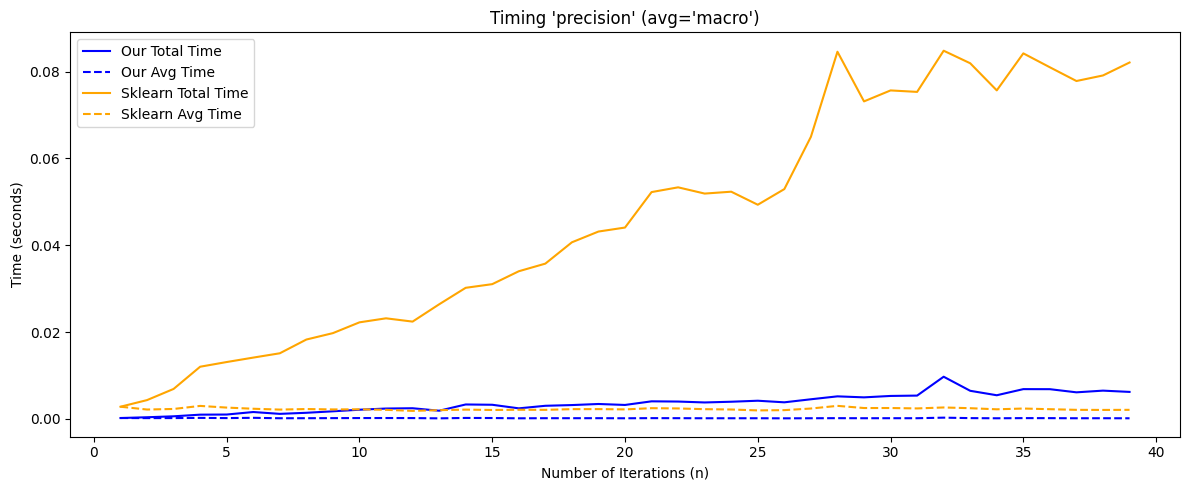

--- per_class ---


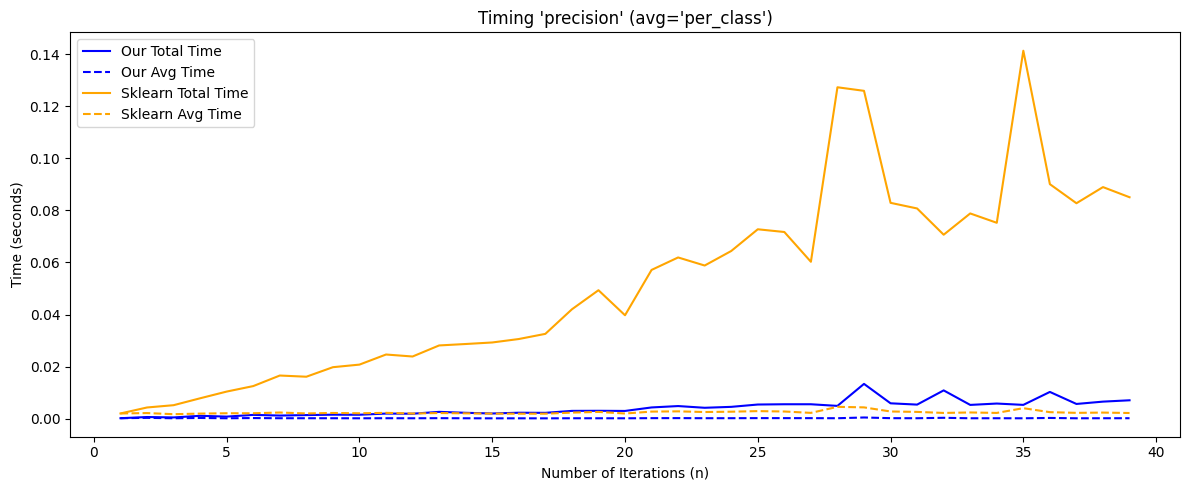

--- weighted ---


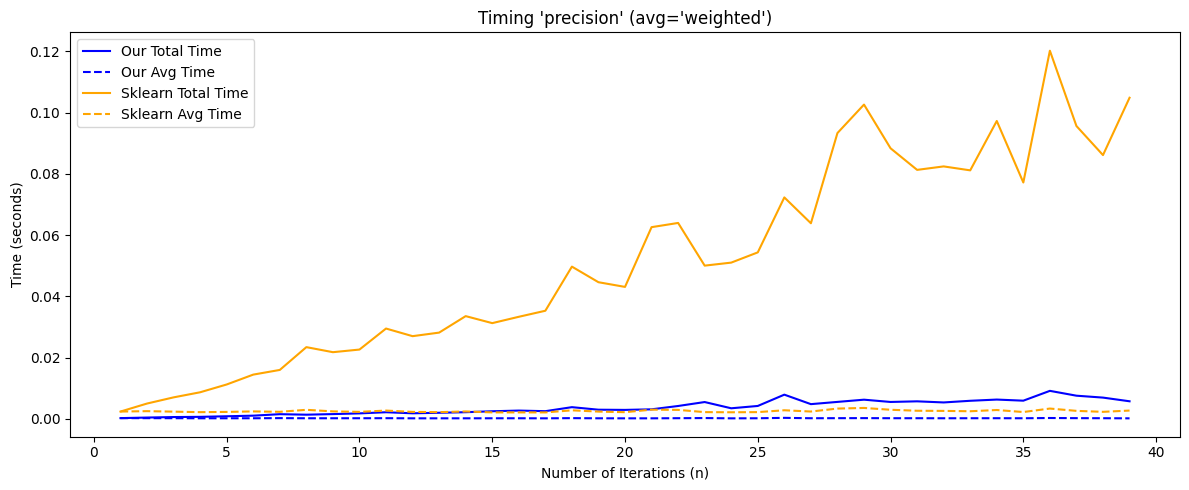

In [22]:
compare_times('precision', precision_score, predictions, actual)

--- micro ---


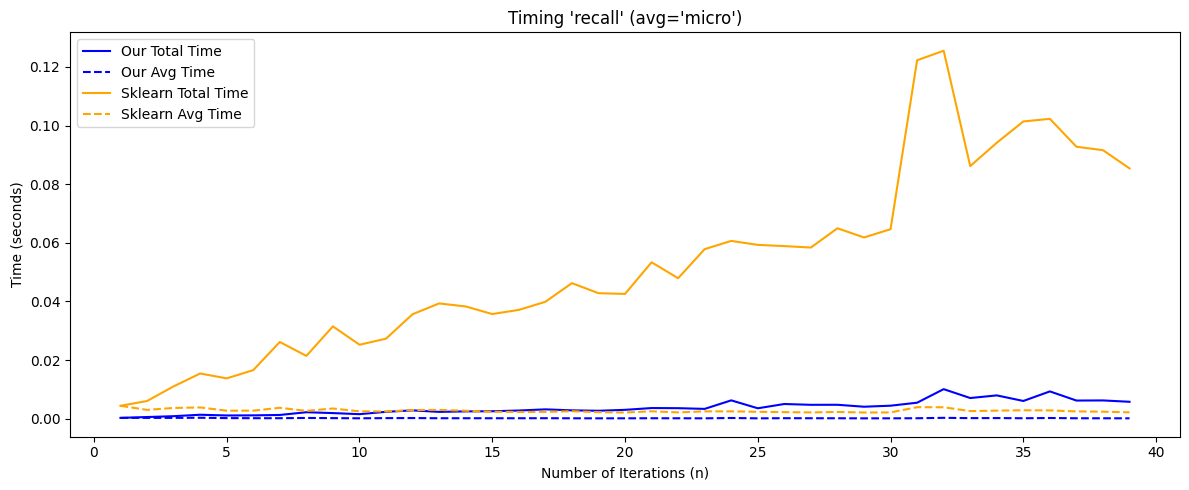

--- macro ---


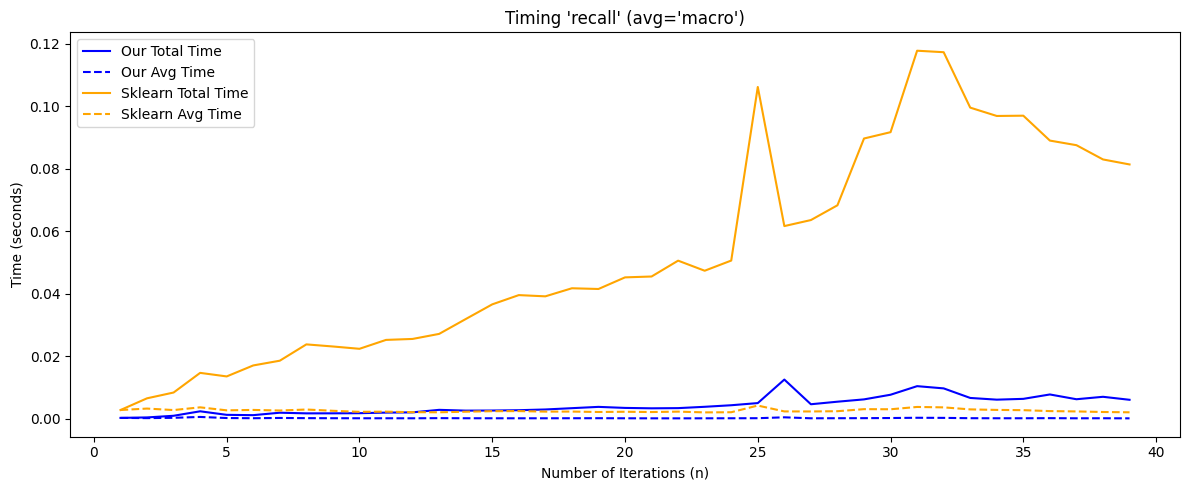

--- per_class ---


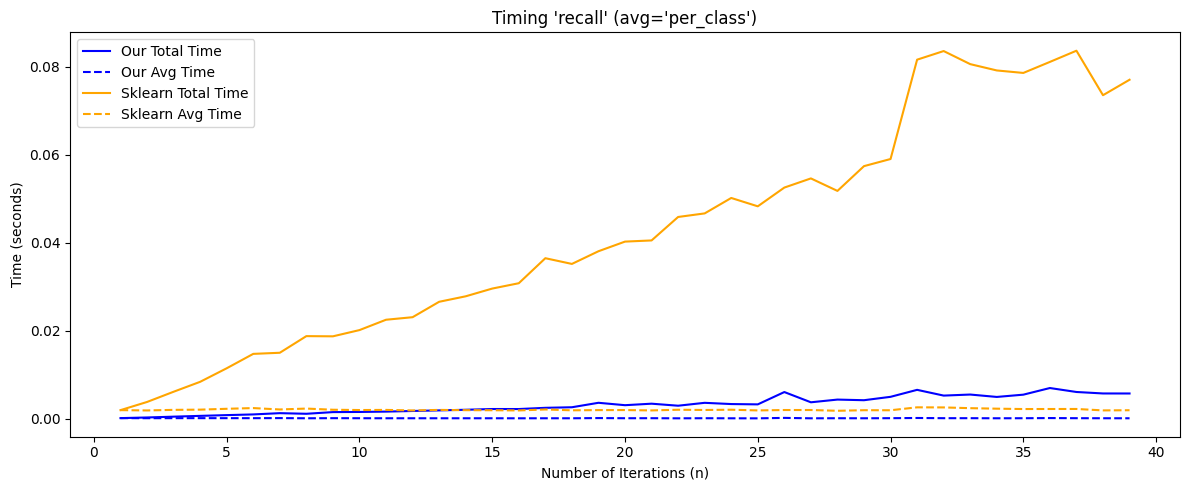

--- weighted ---


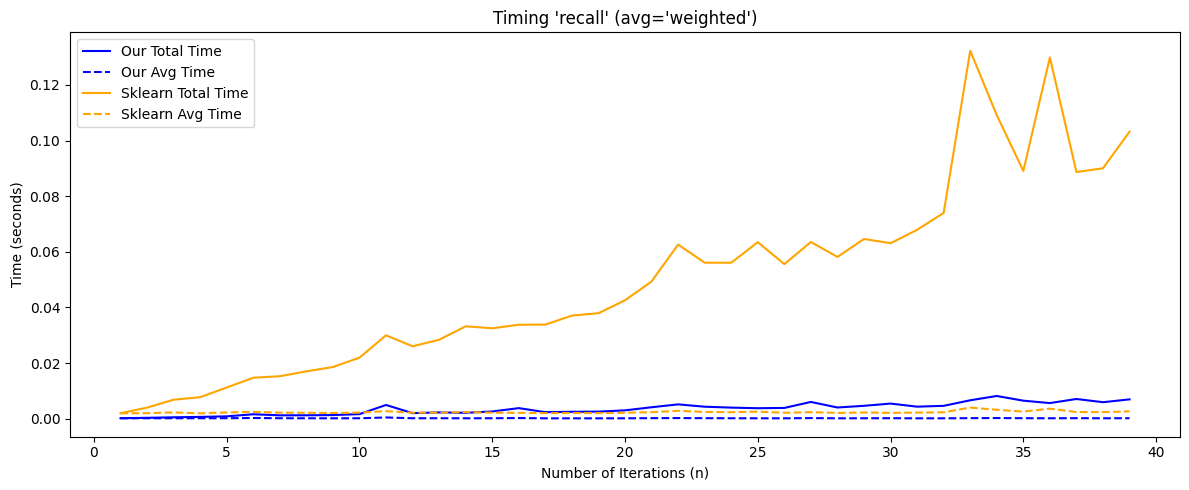

In [23]:
compare_times('recall', recall_score, predictions, actual)

--- micro ---


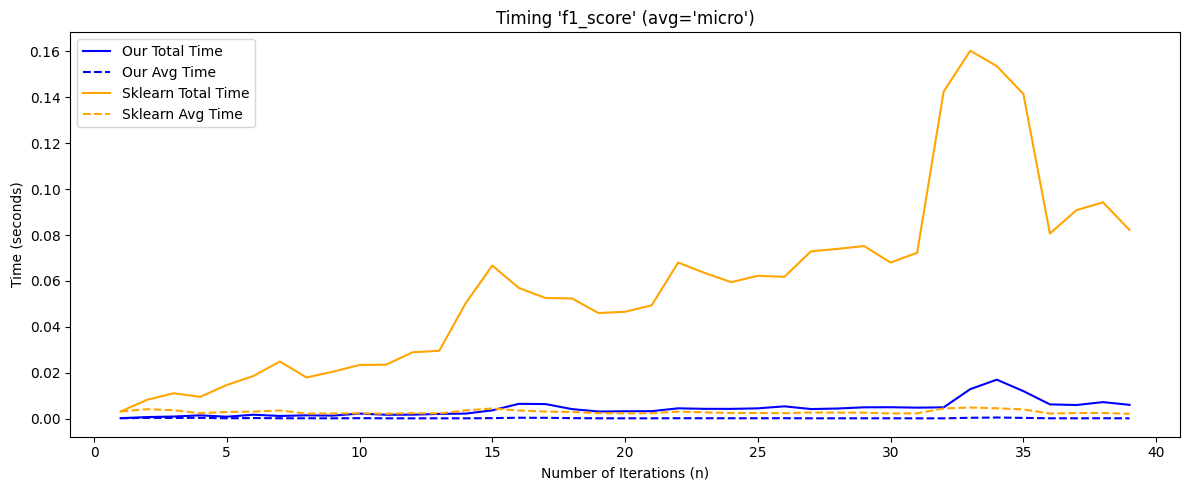

--- macro ---


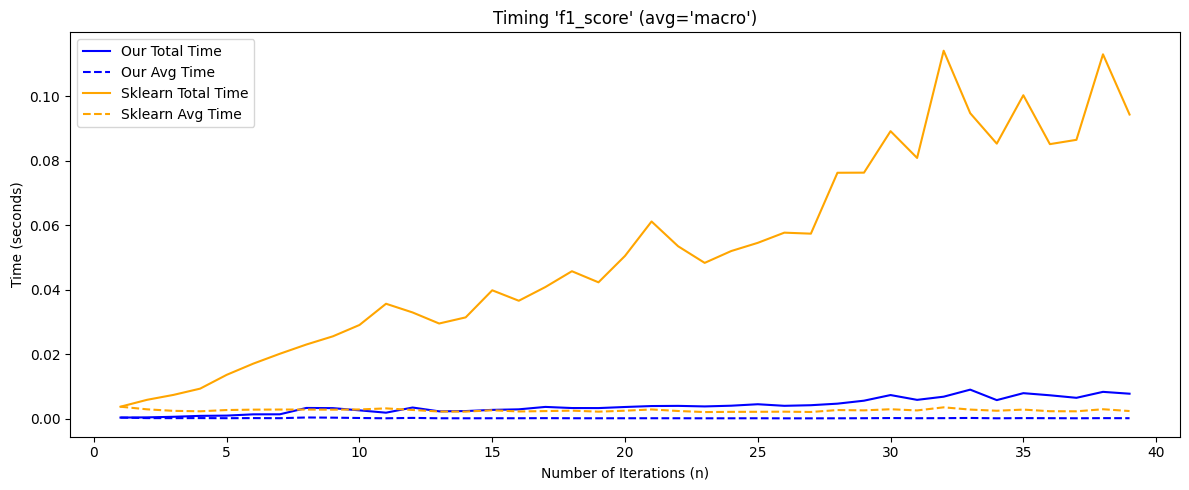

--- per_class ---


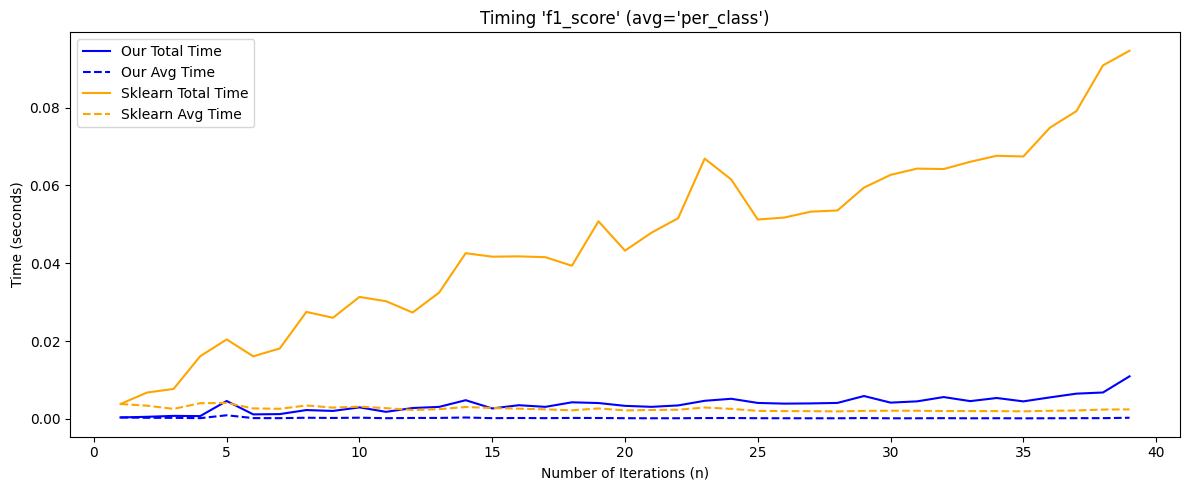

--- weighted ---


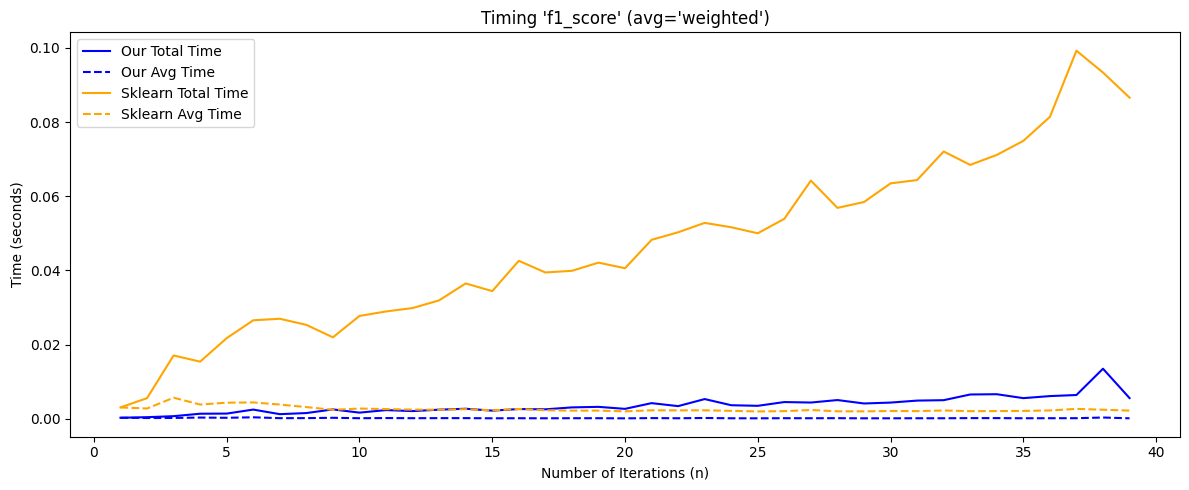

In [24]:
compare_times('f1_score', f1_score, predictions, actual)

#### Students

In [28]:
logistic_regression_students = AbstractClassifier(logistic_regression, x_students, x_test_students, y_train_students)
logistic_regression_students.fit()

predictions_students = logistic_regression_students.predict()
actual_students = y_test_students

ValueError: could not convert string to float: 'GP'